This notebook is the third part of a tutorial on Time Series Analysis using StatsModels.

It is based on Chapter 12 of [*Think Stats*, third edition](https://allendowney.github.io/ThinkStats/).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/tutorial/ts/time_series_03.ipynb).

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Material from the previous notebook

In [4]:
# The following cell downloads the data, which I downloaded September 17, 2024
# from https://www.eia.gov/electricity/data/browser/

In [5]:
filename = "Net_generation_for_all_sectors.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

In [6]:
elec = (
    pd.read_csv("Net_generation_for_all_sectors.csv", skiprows=4)
    .drop(columns=["units", "source key"])
    .set_index("description")
    .replace("--", np.nan)
    .transpose()
    .astype(float)
)

In [7]:
elec.index = pd.date_range(start="2001-01", periods=len(elec), freq="ME")
elec.index[:6]

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30'],
              dtype='datetime64[ns]', freq='ME')

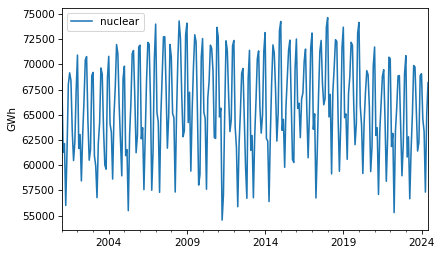

In [8]:
nuclear = elec["United States : nuclear"]
nuclear.plot(label="nuclear")

decorate(ylabel="GWh")

In [9]:
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0")
    plt.ylabel("Original")

    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label="Trend", color="C1")
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2")
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label="Residual", color="C3")
    plt.ylabel("Residual")

    plt.tight_layout()

In [10]:
# The following cell downloads data prepared by Our World in Data,
# which I Downloaded September 18, 2024
# from https://ourworldindata.org/grapher/average-monthly-surface-temperature

# Based on modified data from Copernicus Climate Change Service information (2019)
# with "major processing" by Our World in Data

In [11]:
filename = "monthly-average-surface-temperatures-by-year.csv"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

In [12]:
temp = pd.read_csv("monthly-average-surface-temperatures-by-year.csv")

In [13]:
temp_us = temp.query("Code == 'GHA'")
columns = [str(year) for year in range(2000, 2025)]
temp_series = temp_us.loc[:, columns].transpose().stack()
temp_series.index = pd.date_range(start="2000-01", periods=len(temp_series), freq="M")

/tmp/ipykernel_49651/497900156.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp_series.index = pd.date_range(start="2000-01", periods=len(temp_series), freq="M")


In [14]:
def split_series(series, n=60):
    training = series.iloc[:-n]
    test = series.iloc[-n:]
    return training, test

In [15]:
def MAPE(predicted, actual):
    ape = np.abs(predicted - actual) / actual
    return np.mean(ape) * 100

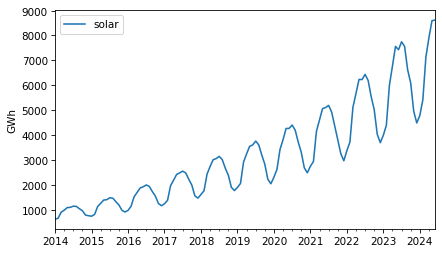

In [16]:
solar = elec["United States : small-scale solar photovoltaic"].dropna()
solar.plot(label="solar")
decorate(ylabel="GWh")

## Autoregression

Seasonal decomposition worked well for modeling and predicting solar production, but in the previous example, it was not very effective for nuclear production.
Let's see if we can do better with a different approach, autoregression.

The first idea of autoregression is that the future will be like the past.
For example, in the time series we've looked at so far, there is a clear annual cycle.
So if you are asked to make a prediction for next June, a good starting place would be last June.

To see how well that might work, let's go back to `nuclear`, which contains monthly electricity production from nuclear generators, and compute differences between the same month in successive years, which are called "year-over-year" differences.

In [17]:
diff = (nuclear - nuclear.shift(12)).dropna()

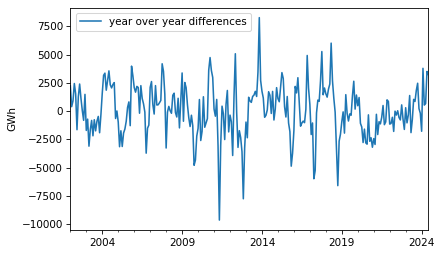

In [18]:
diff.plot(label="year over year differences")
decorate(ylabel="GWh")

The magnitudes of these differences are substantially smaller than the magnitudes of the original series, which suggests the second idea of autoregression, which is that it might be easier to predict these differences, rather than the original values.

Toward that end, let's see if there are correlations between successive elements in the series of differences.
If so, we could use those correlations to predict future values based on previous values.

I'll start by making a `DataFrame`, putting the differences in the first column and putting  the same differences -- shifted by 1, 2, and 3 months -- into successive columns.
These columns are named `lag1`, `lag2`, and `lag3`, because the series they contain have been **lagged** or delayed.

In [19]:
df_ar = pd.DataFrame({"diff": diff})
for lag in [1, 2, 3]:
    df_ar[f"lag{lag}"] = diff.shift(lag)

df_ar = df_ar.dropna()

Here are the correlations between these columns.

In [20]:
df_ar.corr()[["diff"]]

,diff
diff,1.000000
lag1,0.562212
lag2,0.292454
lag3,0.222228


The correlation between `diff` and `lag1` is called **serial correlation** because it is the correlation between successive elements in the series.
The other correlations are called lagged correlations or **autocorrelations** -- the prefix "auto" indicates that we're taking the correlation of the series with itself.

These correlation are strong enough to suggest that they should help with prediction, so let's put them into a multiple regression.
The following function uses the columns from the `DataFrame` to make a Patsy formula with the first column as the dependent variable and the other columns as explanatory variable.

In [21]:
def make_formula(df):
    """Make a Patsy formula from column names."""
    y = df.columns[0]
    xs = " + ".join(df.columns[1:])
    return f"{y} ~ {xs}"

Here are the results of a linear model that predicts the next value in a sequence based on the previous three values.

In [22]:
import statsmodels.formula.api as smf

formula = make_formula(df_ar)
results_ar = smf.ols(formula=formula, data=df_ar).fit()

In [23]:
from thinkstats import display_summary

display_summary(results_ar)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,24.2674,114.674,0.212,0.833,-201.528,250.063
lag1,0.5847,0.061,9.528,0.000,0.464,0.706
lag2,-0.0908,0.071,-1.277,0.203,-0.231,0.049
lag3,0.1026,0.062,1.666,0.097,-0.019,0.224


R-squared:,0.3239


Now we can use the `predict` method to generate predictions for the past values in the series.
Here's what these retrodictions look like compared to the data.

In [24]:
pred_ar = results_ar.predict(df_ar)

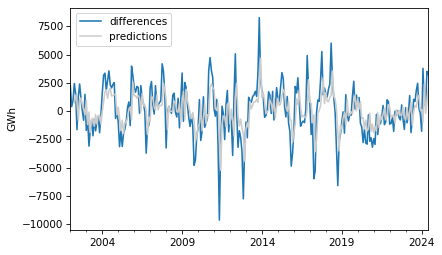

In [25]:
diff.plot(label="differences")
pred_ar.plot(color="0.8", label="predictions")
decorate(ylabel="GWh")

The predictions are good in some places, but the $R^2$ value is only about 0.319, so there is room for improvement.

In [26]:
resid_ar = (diff - pred_ar).dropna()

In [27]:
R2 = 1 - resid_ar.var() / diff.var()
R2

0.3190252265690783

One way to improve the predictions is to compute the residuals from this model and use another model to predict the residuals -- which is the third idea of autoregression.

## Moving Average

Suppose it's June 2019, and you are asked to make a prediction for June 2020.
You first guess might be that this year's value will be repeated next year.

Now suppose it's May 2020, and you are asked to revise your prediction for June 2020.
You could use the results from the last three months, and the autocorrelation model from the previous section, to predict the year-over-year difference.

Finally, suppose you check the predictions for the last few months, and see that they have been consistently too low.
That suggests that the prediction for next month might also be too low, so you could revise it upward.
The underlying assumption is that recent prediction errors predict future prediction errors.

To see whether they do, we can make a `DataFrame` with the residuals from the autoregression model in the first column, and lagged versions of the residuals in the other columns.
For this example, I'll use lags of 1 and 6 months.

In [28]:
df_ma = pd.DataFrame({"resid": resid_ar})

for lag in [1, 6]:
    df_ma[f"lag{lag}"] = resid_ar.shift(lag)

df_ma = df_ma.dropna()

We can use `ols` to make an autoregression model for the residuals.
This part of the model is called a "moving average" because it reduces variability in the predictions in a way that's analogous to the effect of a moving average.
I don't find that term particularly helpful, but it is conventional.

Anyway, here's a summary of the autoregression model for the residuals.

In [29]:
formula = make_formula(df_ma)
results_ma = smf.ols(formula=formula, data=df_ma).fit()
display_summary(results_ma)

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-14.0016,114.697,-0.122,0.903,-239.863,211.860
lag1,0.0014,0.062,0.023,0.982,-0.120,0.123
lag6,-0.1592,0.063,-2.547,0.011,-0.282,-0.036


R-squared:,0.0247


The $R^2$ is quite small, so it looks like this part of the model won't help very much.
But the p-value for the 6-month lag is small, which suggests that it contributes more information than we'd expect by chance.

Now we can use the model to generate retrodictions for the residuals.

In [30]:
pred_ma = results_ma.predict(df_ma)

Then, to generate retrodictions for the year-over-year differences, we add the adjustment from the second model to the retrodictions from the first.

In [31]:
pred_diff = pred_ar + pred_ma

The $R^2$ value for the sum of the two models is about 0.332, which is a little better than the result without the moving average adjustment (0.319).

In [32]:
resid_ma = (diff - pred_diff).dropna()

In [33]:
R2 = 1 - resid_ma.var() / diff.var()
R2

0.3315101001391231

Next we'll use these year-over-year differences to generate retrodictions for the original values.

## Retrodiction with Autoregression

To generate retrodictions, we'll start by putting the year-over-year differences in a `Series` that's aligned with the index of the original.

In [34]:
pred_diff = pd.Series(pred_diff, index=nuclear.index)

Using `isna` to check for `NaN` values, we find that the first 21 elements of the new `Series` are missing.

In [35]:
n_missing = pred_diff.isna().sum()

That's because we shifted the `Series` by 12 months to compute year-over-year differences, then we shifted the differences 3 months for the first autoregression model, and we shifted the residuals of the first model by 6 months for the second model.
Each time we shift a series like this, we lose a few values at the beginning of the `Series`, and the sum of these shifts is 21.

So before we can generate retrodictions, we have to prime the pump by copying the first 21 elements from the original into a new `Series`.

In [36]:
pred_series = pd.Series(index=nuclear.index, dtype=float)
pred_series.iloc[:n_missing] = nuclear.iloc[:n_missing]

Now we can run the following loop, which fills in the elements from index 21 (which is the 22nd element) to the end.
Each element is the sum of the value from the previous year and the predicted year-over-year difference.

In [37]:
for i in range(n_missing, len(pred_series)):
    pred_series.iloc[i] = pred_series.iloc[i - 12] + pred_diff.iloc[i]

Now we'll replace the elements we copied with `NaN` so we don't get credit for "predicting" the first 21 values perfectly.

In [38]:
pred_series[:n_missing] = np.nan

Here's what the retrodictions look like compared to the original.

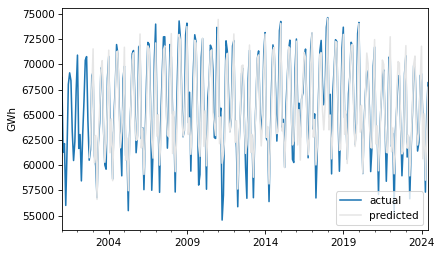

In [39]:
nuclear.plot(label="actual")
pred_series.plot(color="0.9", label="predicted")
decorate(ylabel="GWh")

They look pretty good, and the $R^2$ value is about 0.86.

In [40]:
resid = (nuclear - pred_series).dropna()

In [41]:
R2 = 1 - resid.var() / nuclear.var()
R2

0.8586566911201015

The model we used to compute these retrodictions is called SARIMA, which is one of a family of models called ARIMA.
Each part of these acronyms refers to an element of the model.

* **S** stands for seasonal, because the first step was to compute differences between values separated by one seasonal period.

* **AR** stands for autoregression, which we used to model lagged correlations in the differences.

* **I** stands for integrated, because the iterative process we used to compute `pred_series` is analogous to integration in calculus.

* **MA** stands for moving average, which is the conventional name for the second autoregression model we ran with the residuals from the first.

ARIMA models are powerful and versatile tools for modeling time series data.

## ARIMA

StatsModel provides a library called `tsa`, which stands for "time series analysis" -- it includes a function called `ARIMA` that fits ARIMA models and generates forecasts.

To fit the SARIMA model we developed in the previous sections, we'll call this function with two tuples as arguments: `order` and `seasonal_order`.
Here are the values in `order` that correspond to the model we used in the previous sections.

In [42]:
order = ([1, 2, 3], 0, [1, 6])

The values in `order` indicate:

* Which lags should be included in the AR model -- in this example it's the first three.

* How many times it should compute differences between successive elements -- in this example it's 0 because we computed a seasonal difference instead, and we'll get to that in a minute.

* Which lags should be included in the MA model -- in this example it's the first and sixth.

Now here are the values in `seasonal_order`.

In [43]:
seasonal_order = (0, 1, 0, 12)

The first and third elements are 0, which means that this model does not include seasonal AR or seasonal MA.
The second element is 1, which means it computes seasonal differences -- and the last element is the seasonal period.

Here's how we use `ARIMA` to make and fit this model.

In [44]:
import statsmodels.tsa.api as tsa

model = tsa.ARIMA(nuclear, order=order, seasonal_order=seasonal_order)
results_arima = model.fit()
display_summary(results_arima)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.0458,0.379,0.121,0.904,-0.697,0.788
ar.L2,-0.0035,0.116,-0.030,0.976,-0.230,0.223
ar.L3,0.0375,0.049,0.769,0.442,-0.058,0.133
ma.L1,0.2154,0.382,0.564,0.573,-0.533,0.964
ma.L6,-0.0672,0.019,-3.500,0.000,-0.105,-0.030
sigma2,3.473e+06,1.9e-07,1.83e+13,0.000,3.47e+06,3.47e+06


The results include estimated coefficients for the three lags in the AR model, the two lags in the MA model, and `sigma2`, which is the variance of the residuals.

From `results_arima` we can extract `fittedvalues`, which contains the retrodictions.
For the same reason there were missing values at the beginning of the retrodictions we computed, there are incorrect values at the beginning of `fittedvalues`, which we'll drop.

In [45]:
fittedvalues = results_arima.fittedvalues[n_missing:]

The fitted values are similar to the ones we computed, but not exactly the same -- probably because `ARIMA` handles the initial conditions differently. 

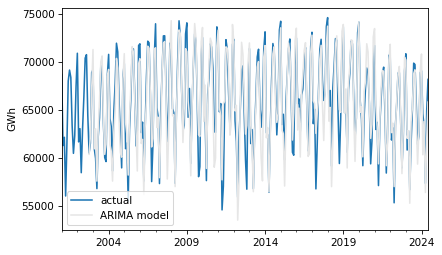

In [46]:
nuclear.plot(label="actual")
fittedvalues.plot(color="0.9", label="ARIMA model")
decorate(ylabel="GWh")

The $R^2$ value is also similar but not precisely the same.

In [47]:
resid = fittedvalues - nuclear
R2 = 1 - resid.var() / nuclear.var()
R2

0.8262717330784233

The `ARIMA` function makes it easy to experiment with different versions of the model.

As an exercise, try out different values in `order` and `seasonal_order` and see if you can  find a model with higher $R^2$.

## Prediction with ARIMA

The object returned by `ARIMA` provides a method called `get_forecast` that generates predictions.
To demonstrate, we'll split the time series into a training and test set, and fit the same model to the training set.

In [61]:
training, test = split_series(nuclear)
model = tsa.ARIMA(training, order=order, seasonal_order=seasonal_order)
results_training = model.fit()

We can use the result to generate a forecast for the test set.

In [62]:
forecast = results_training.get_forecast(steps=len(test))

The result is an object that contains an attribute called `forecast_mean` and a function that returns a confidence interval.

In [63]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_ci.columns = ["lower", "upper"]

We can plot the results like this and compare them to the actual time series.

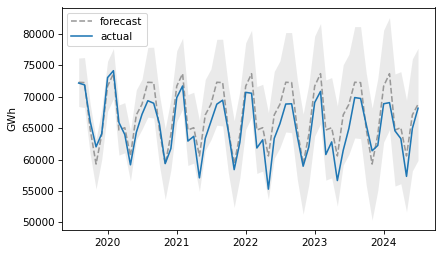

In [64]:
plt.fill_between(
    forecast_ci.index,
    forecast_ci.lower,
    forecast_ci.upper,
    lw=0,
    color="0.6",
    alpha=0.2,
)
plt.plot(forecast_mean.index, forecast_mean, "--", label="forecast", color="0.6")
plt.plot(test.index, test, label="actual")
decorate(ylabel="GWh")

The actual values fall almost entirely within the confidence interval of the predictions.
Here's the MAPE of the predictions.

In [65]:
MAPE(forecast_mean, test)

3.381754924564627

The predictions are off by 3.38% on average, somewhat better than the results we got from seasonal decomposition (3.81%).

ARIMA is more versatile than seasonal decomposition, and can often make better predictions.
In this time series, the autocorrelations are not especially strong, so the advantage of ARIMA is modest.

### Exercise

Let's see how well an ARIMA model fits production from hydroelectric generators in the United States.
Here's what the time series looks like from 2001 to 2024.

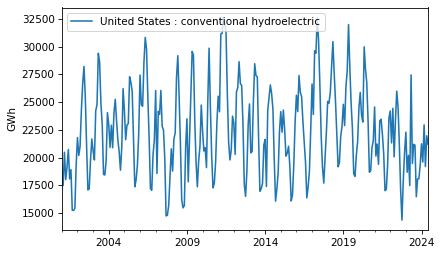

In [53]:
hydro = elec["United States : conventional hydroelectric"]
hydro.plot()
decorate(ylabel="GWh")

Fit a SARIMA model to this data with a seasonal period of 12 months.
Experiment with different lags in the autoregression and moving average parts of the model and see if you can find a combination that maximizes the $R^2$ value of the model.
Generate a five-year forecast and plot it along with its confidence interval.

NOTE: Depending on what lags you include in the model, you might find that the first 12 to 24 elements of the fitted values are not reliable. You might want to remove them before plotting or computing $R^2$.

In [54]:
# Solution

model = tsa.ARIMA(hydro, order=([1, 6], 0, [6]), seasonal_order=(0, 1, 0, 12))
results_arima = model.fit()
display_summary(results_arima)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.5387,0.039,13.680,0.000,0.461,0.616
ar.L6,-0.4041,0.046,-8.722,0.000,-0.495,-0.313
ma.L6,0.9405,0.043,22.009,0.000,0.857,1.024
sigma2,4.437e+06,3.58e+05,12.396,0.000,3.74e+06,5.14e+06


In [55]:
# Solution

n_missing = 24
fittedvalues = results_arima.fittedvalues[n_missing:]

In [56]:
# Solution

resid = hydro - fittedvalues
R2 = 1 - resid.var() / nuclear.var()
R2

0.8057348501209282

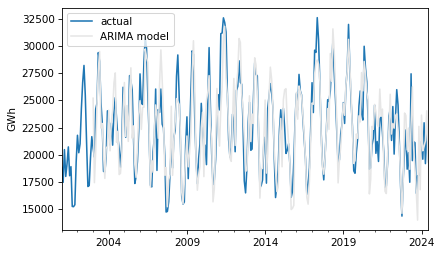

In [57]:
# Solution

hydro.plot(label="actual")
fittedvalues.plot(color="0.9", label="ARIMA model")
decorate(ylabel="GWh")

In [58]:
# Solution

forecast = results_arima.get_forecast(steps=60)

In [59]:
# Solution

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_ci.columns = ["lower", "upper"]

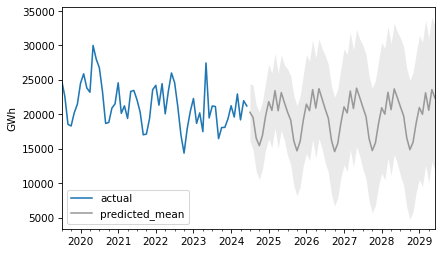

In [60]:
# Solution

recent = hydro.iloc[-60:]
recent.plot(label="actual")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.lower,
    forecast_ci.upper,
    lw=0,
    color="0.6",
    alpha=0.2,
)
forecast_mean.plot(color="0.6")
decorate(ylabel="GWh")

## Glossary

-   **time series**: A dataset where each value is associated with a specific time, often representing measurements taken at regular intervals.

-   **seasonal decomposition:** A method of splitting a time series into a long-term trend, a repeating seasonal component, and a residual component.

-   **retrodiction:** A prediction for a value observed in the past, often used to test or validate a model.

-   **window**: A sequence of consecutive values in a time series, used to compute a moving average.

-   **moving average**: A time series computed by averaging values in overlapping windows to smooth fluctuations.

-   **serial correlation**: The correlation between a time series and a shifted or lagged version of itself.

-   **lag**: The size of the shift in a serial correlation or autocorrelation.

-   **autocorrelation**: The correlation between a time series and its lagged values, computed with different lags.


[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)